# Cambio Relativo en las Series Históricas

Se estudia la diferencia relativa de las observaciones de la calidad del aire del 2020 respecto a los valores esperados según los datos meteorológicos medidos a partir del modelo predictivo.

$$
RC_i (\%)  = 100 \cdot \frac{C_{i, obs} - C_{i, pred}}{C_{i, pred}}
$$

donde $C_i$ es la concentración del contaminante en el día $i$ del año.

In [1]:
library(tidyverse)
library(ggplot2)

setwd("~/Repositories/AirQualityCOVID/")
source("src/Analysis/functions.R")

source("src/functions.R")

── Attaching packages ───────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=15,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
html.variable <- list("no" = "NO",
                      "no2" = "NO<sub>2</sub>",
                      "o3" = "O<sub>3</sub>",
                      "pm10" = "PM10",
                      "pm2.5" = "PM2.5"
                     )
r.variable <- c("no" = expression(NO),
                "no2" = expression(NO[2]),
                "o3" = expression(O[3]),
                "pm10" = expression(PM10),
                "pm2.5" = expression(PM2.5)
               )

In [4]:
periods <- list(
            # Prelockdown
            "pre Confinamiento" = lubridate::ymd("2020-01-01"),

            # lockdown
            "Confinamiento" = lubridate::ymd("2020-03-14"),
            #end.lockdown = ymd_hms("2020-04-28 00:00:00"),

            # poslockdown
            "Fases" = lubridate::ymd("2020-05-01"),
            "Nueva Normalidad" = lubridate::ymd("2020-06-21"),

            # New lockdown
            "Segundo Estado de Alarma" = lubridate::ymd("2020-10-25"),
            end.year = lubridate::ymd("2020-12-31")
        )
    
   

In [5]:
data.df <- read.csv("data/Results/predictions.csv") %>%
            data.as.datetime(column = "date", FUN="ymd")

In [6]:
load("data/all/data_AQ.rda")

old <- data_AQ %>% 
        filter(lubridate::year(date) < 2020) %>% 
        select(date, site, variable, value)
lubridate::year(old$date) <- 2020

old.mean <- old %>%
                group_by(date, variable, site) %>%
                summarise(value = mean(value, na.rm=T)) %>%
                rename(hist = value)

`summarise()` has grouped output by 'date', 'variable'. You can override using the `.groups` argument.



In [7]:
results <- merge(data.df,
                 old.mean,
                 by = c("date", "site", "variable"),
                 all.x = T, all.y=F
                ) %>%
            pivot_longer(cols = c("pred", "hist"), 
                         names_to = "type") %>%
            relocate(type, .before = where(is.numeric)) %>%
            mutate(diff = relative.change(obs, value)) %>%
            sep.periods(periods)

In [8]:
diff.results <- results  %>%
        group_by(periods, variable, site, type) %>%
        summarise(mean = mean(diff, na.rm=T),
                  std = sd(diff, na.rm=T))

`summarise()` has grouped output by 'periods', 'variable', 'site'. You can override using the `.groups` argument.



In [9]:
change.municipios <- group.municipio(diff.results) %>%
            data.frame %>%
            mutate_if(is.factor, as.character)

`summarise()` has grouped output by 'variable', 'Municipio', 'periods'. You can override using the `.groups` argument.



Warning message:
“Removed 9 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 9 rows containing non-finite values (stat_boxplot).”


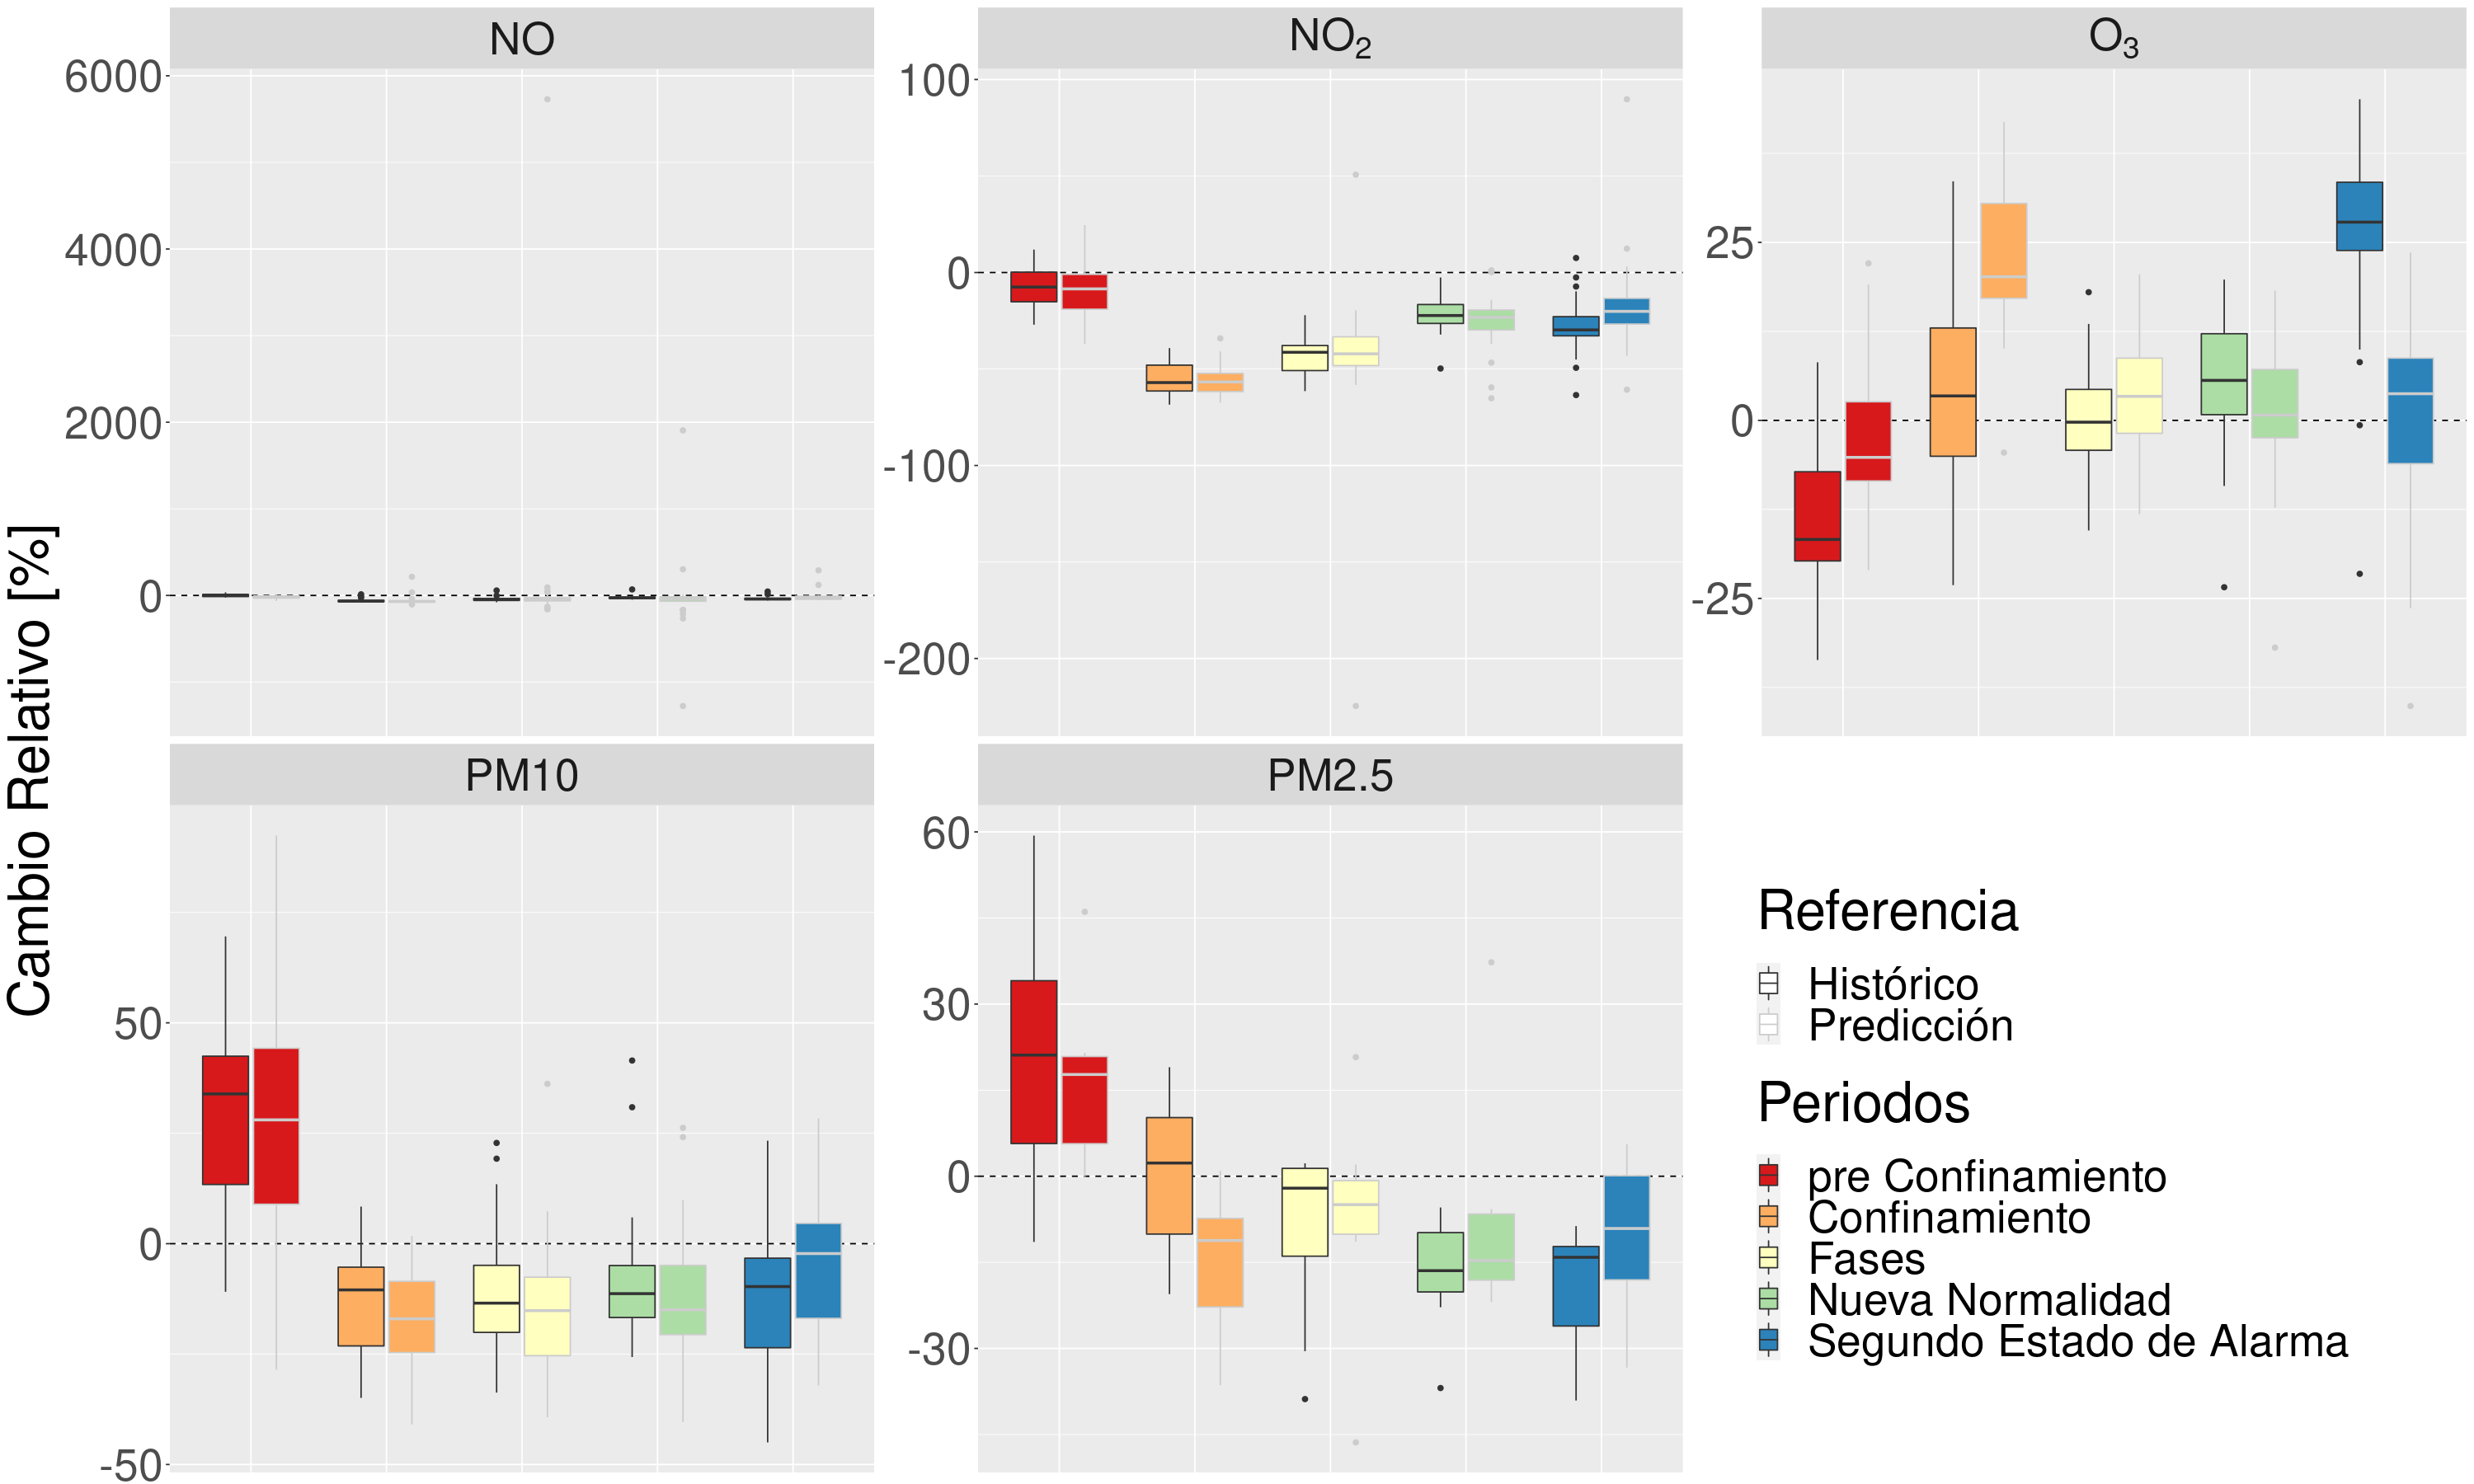

In [10]:
plot.df <- change.municipios

plot.df$periods <- factor(plot.df$periods,
                          levels = names(periods),
                          ordered = TRUE)
plot.df$variable <- factor(plot.df$variable, 
                           labels=r.variable)

plt <- ggplot(plot.df) +
            geom_hline(yintercept=0, 
                       linetype="dashed", 
                       color = "black") +
            geom_boxplot(aes(x=periods, y=mean, 
                             fill=periods, color=type
                            )) + 
            theme(legend.position=c(0.82,0.25),
                  text = element_text(size=40),

                  #legend.title = element_text(size = 45),
                  #legend.text = element_text(size = 45),

                  axis.title.x=element_blank(),
                  axis.text.x=element_blank(),
                  #axis.text.x = element_text(angle=20, hjust=0.5, vjust=0.7)
                  axis.ticks.x=element_blank()
                 ) +
            scale_y_continuous(name="Cambio Relativo [%]") +
            #scale_x_discrete(name="Periods")+
            #scale_fill_discrete(name="Periods") +
            scale_fill_brewer(name="Periodos", palette="Spectral") +
            scale_color_grey(name="Referencia", labels=c("hist" = "Histórico",
                                                           "pred" = "Predicción")) +
            facet_wrap(~variable, ncol=3, scale="free_y", 
                       labeller = labeller(variable=label_parsed))

ggsave(plt, 
       filename="Plots/Results/vs_Predictions/boxplot.png", 
       width=25, height=15)

plt

In [11]:
cleaned.df <- data.frame()
outlier.df <- data.frame()

for (tp in levels(as.factor(change.municipios$type))){
    for (pr in levels(as.factor(change.municipios$periods))) {
        for (pll in levels(as.factor(change.municipios$variable))) {
            dat.rw <- change.municipios %>%
                        filter(periods == pr,
                               variable == pll,
                               type == tp
                              )

            outlier <- boxplot.stats(dat.rw$mean)$out

            if (length(outlier) > 0) {
                in.position <- which(dat.rw$mean %in% outlier)

                cleaned.df <- rbind(cleaned.df,
                                    dat.rw[-in.position, ])
                outlier.df <- rbind(outlier.df,
                                    dat.rw[in.position, ])
            } else {
                cleaned.df <- rbind(cleaned.df,
                                    dat.rw)
            }
        }
    }
}

In [12]:
head(outlier.df)

,variable,Municipio,periods,type,mean,latitude,longitude
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
7,no,Burgos,Confinamiento,hist,13.296796,42.35083,-3.67556000
8,no,Castellón de la Plana,Confinamiento,hist,-11.503013,39.98889,-0.02611111
31,no,Valladolid,Confinamiento,hist,-25.583054,41.63204,-4.73916666
71,no,Burgos,Fases,hist,57.448925,42.35083,-3.67556000
81,no,Castellón de la Plana,Fases,hist,-1.532141,39.98889,-0.02611111
11,pm10,Ourense,Fases,hist,22.803206,42.35300,-7.87790000


In [13]:
write.csv(outlier.df, 
          "data/Results/vs_Predictions/outliers.csv",
          row.names=FALSE)

outlier.df %>% 
    filter(
           variable == "no2",
           #periods == "lockdown"
          ) %>%
    select(-latitude, -longitude)

,variable,Municipio,periods,type,mean
,<chr>,<chr>,<chr>,<chr>,<dbl>
27,no2,Santander,Nueva Normalidad,hist,-49.7570262
17,no2,Málaga,Segundo Estado de Alarma,hist,7.5271149
18,no2,Marbella,Segundo Estado de Alarma,hist,-49.3827712
25,no2,Santander,Segundo Estado de Alarma,hist,-63.5082198
321,no2,Zaragoza,Segundo Estado de Alarma,hist,-2.5643518
75,no2,Burgos,Confinamiento,pred,-34.1254754
13,no2,Huelva,Fases,pred,50.6823077
26,no2,San Sebastián,Fases,pred,-224.6378498
85,no2,Castellón de la Plana,Nueva Normalidad,pred,-59.5569301


In [14]:
mean.change <- change.municipios %>% 
                    filter(type == "pred") %>%
                    group_by(periods, variable) %>%
                    summarise(Mean = mean(mean, na.rm=T),
                              Median = median(mean, na.rm=T),
                              Q3 = quantile(mean, na.rm = T, 0.75),
                              Q1 = quantile(mean, na.rm = T, 0.25),
                              IQR = Q3-Q1
                             )
resume.change <- mean.change %>%
                    mutate(result = paste("$",round(Mean, 1),
                                          "\\pm", round(IQR/2, 1), "$")) %>%
                    select(periods, variable, result) %>%
                    pivot_wider(names_from = variable, values_from = result)

write_csv(mean.change,
          "data/Results/vs_Predictions/change_stats.csv")
write_csv(resume.change,
          "data/Results/vs_Predictions/change_resume.csv")

resume.change

`summarise()` has grouped output by 'periods'. You can override using the `.groups` argument.



periods,no,no2,o3,pm10,pm2.5
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Confinamiento,$ -59.3 \pm 7 $,$ -55.8 \pm 4.7 $,$ 22 \pm 6.7 $,$ -17.2 \pm 8.1 $,$ -14.9 \pm 7.7 $
Fases,$ 125.7 \pm 18 $,$ -43.8 \pm 7.5 $,$ 3.4 \pm 5.3 $,$ -13.6 \pm 8.9 $,$ -6.7 \pm 4.7 $
Nueva Normalidad,$ -25.1 \pm 25.9 $,$ -25.3 \pm 5.2 $,$ 1.1 \pm 4.8 $,$ -11.5 \pm 7.8 $,$ -8.5 \pm 5.8 $
pre Confinamiento,$ -19.3 \pm 11.5 $,$ -10.2 \pm 9 $,$ -3.4 \pm 5.6 $,$ 27 \pm 17.7 $,$ 15.6 \pm 7.6 $
Segundo Estado de Alarma,$ -14.2 \pm 16.8 $,$ -17.6 \pm 6.7 $,$ 0.5 \pm 7.4 $,$ -4.6 \pm 10.8 $,$ -10.8 \pm 9.1 $


Warning message:
“Removed 9 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 9 rows containing non-finite values (stat_boxplot).”


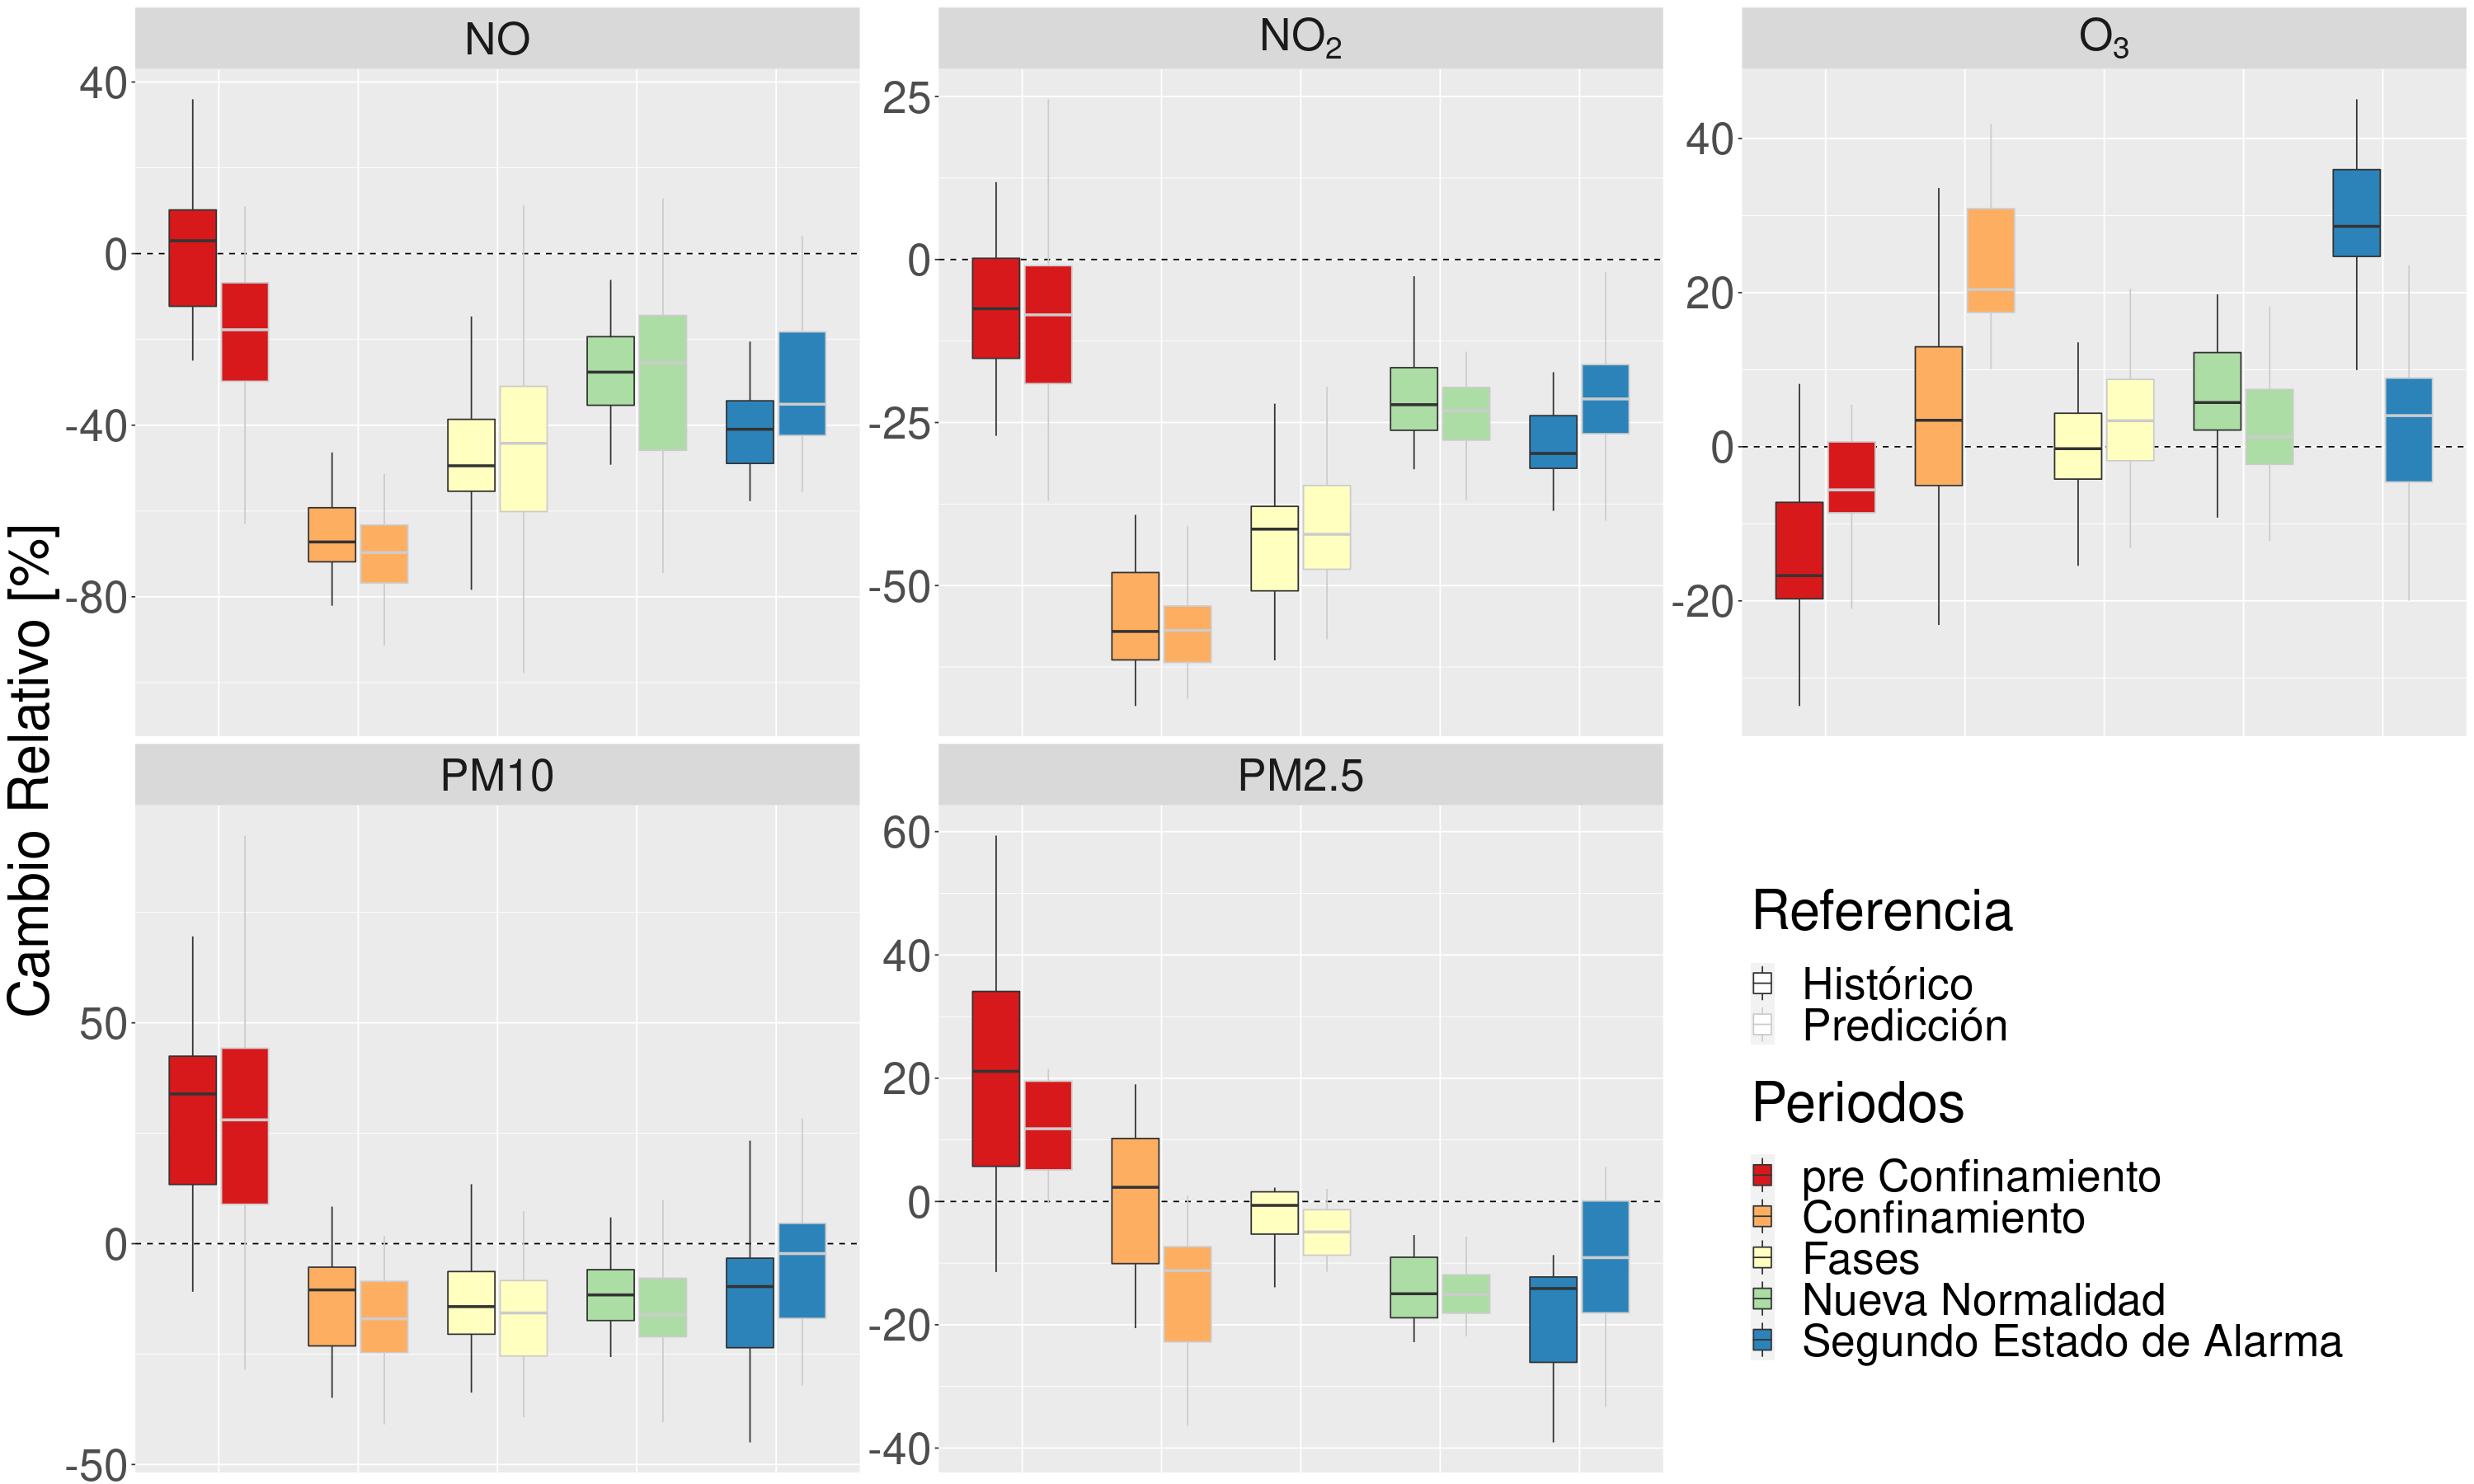

In [15]:
plot.df <- cleaned.df

plot.df$periods <- factor(plot.df$periods,
                          levels = names(periods),
                          ordered = TRUE)
plot.df$variable <- factor(plot.df$variable, 
                           labels=r.variable)

plt <- ggplot(plot.df) +
            geom_hline(yintercept=0, 
                       linetype="dashed", 
                       color = "black") +
            geom_boxplot(aes(x=periods, y=mean, 
                             fill=periods, color=type
                            ),
                         outlier.shape = NA) + 
            theme(legend.position=c(0.82,0.25),#"top",
                  text = element_text(size=40),

                  #legend.title = element_text(size = 45),
                  #legend.text = element_text(size = 45),

                  axis.title.x=element_blank(),
                  axis.text.x=element_blank(),
                  #axis.text.x = element_text(angle=20, hjust=0.5, vjust=0.7)
                  axis.ticks.x=element_blank()
                 ) +
            scale_y_continuous(name="Cambio Relativo [%]") +
            #scale_x_discrete(name="Periods")+
            #scale_fill_discrete(name="Periods") +
            scale_fill_brewer(name="Periodos", palette="Spectral") +
            scale_color_grey(name="Referencia", labels=c("hist" = "Histórico",
                                                           "pred" = "Predicción")) +
            facet_wrap(~variable, ncol=3, scale="free_y", 
                       labeller = labeller(variable=label_parsed))

ggsave(plt, 
       filename="Plots/Results/vs_Predictions/cleaned_boxplot.png", 
       width=25, height=15)

plt

---

In [16]:
library(leaflet)
library(leaflet.extras)
library(htmlwidgets)
library(htmltools)

In [17]:
variable <- "no2"

In [20]:
rr <- tags$div(HTML(paste(
    "<h3>", html.variable[[variable]],"</h3>"))
 ) 

beatCol <- colorNumeric(palette = "Spectral", #'RdYlGn',
                        domain = c(min(cleaned.df$mean, na.rm=T), 
                                   -min(cleaned.df$mean, na.rm=T)),
                        na.color = "transparent",
                        reverse = T,
                        
                       )

map <- leaflet(cleaned.df %>%
                    filter(type == "pred"),
               options = leafletOptions(minZoom = 5, 
                                        maxZoom = 9)) %>%
            addControl(rr, position = "topright")  %>%
            addProviderTiles(providers$CartoDB.Positron)%>% 
            #addTiles() %>% # Add default OpenStreetMap map tiles
            addLayersControl(position="bottomleft", 
                             baseGroups = names(periods)[-6],
                             options = layersControlOptions(
                                         collapsed = FALSE
                                         )
                            )%>% 
            addCircleMarkers(~longitude, 
                             ~latitude, 
                             color=~beatCol(mean),
                             radius=10,
                             fillOpacity=0.9,
                             stroke=FALSE,
                             group=~periods,
                             popup = paste(cleaned.df$Municipio, ": ",
                                           trunc(cleaned.df$mean), "%", sep="")
                            )%>%
            addLegend("bottomright", 
                       pal = beatCol, 
                       values = ~mean,
                       title = "Relative Change %",
                       labFormat = labelFormat(suffix = "%"),
                       opacity = 1,
                       )

map

HTML widgets cannot be represented in plain text (need html)

In [21]:
library(htmlwidgets)
saveWidget(map, file=paste("~/Repositories/AirQualityCOVID/",
                           "Plots/Results/vs_Predictions/",
                           variable, "-change_map.html", sep=""))